In [1]:
# https://deeplearningcourses.com/c/deep-reinforcement-learning-in-python
# https://www.udemy.com/deep-reinforcement-learning-in-python
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future
# Inspired by https://github.com/dennybritz/reinforcement-learning

import gym
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from q_learning_bins import plot_running_avg

In [2]:
class HiddenLayer:
    def __init__(self, M1, M2, fn=tf.tanh):
        #Initialize w
        self.w = tf.Variable(tf.random_normal(shape=(M1, M2)))
        self.fn = fn
        
    def forward(self, x):
        return self.fn(tf.matmul(x, self.w))

In [3]:
class PolicyModel:
    def __init__(self, env, layers):
        self.actionSize  = env.action_space.n        
        
        #create a placehold for status
        sample = env.observation_space.sample()
        self.x = tf.placeholder(tf.float32, shape=(None, sample.shape[0]))
        
        #create a placehold for action
        self.action = tf.placeholder(tf.int32, shape=(None, ))
        onehot = tf.one_hot(self.action, self.actionSize)
        
        #create a placehold for G
        self.G = tf.placeholder(tf.float32, shape=(None, ))
        
        #create a model according to layers
        M1 = sample.shape[0]
        output = self.x
        for layer in layers:            
            output = HiddenLayer(M1, layer).forward(output)                
            M1 = layer
            
        #create the softmax layer
        output = HiddenLayer(M1, self.actionSize, tf.nn.softmax).forward(output)        
        self.output = tf.reshape(output, [-1])        
        #print ("shape for output and onehot:")
        #print (output.get_shape().as_list())
        #print (onehot.get_shape().as_list())
        
        cost = - self.G * tf.log(tf.reduce_sum(onehot * output))
        # self.train_op = tf.train.AdamOptimizer(1e-1).minimize(cost)
        self.train_op = tf.train.AdagradOptimizer(1e-1).minimize(cost)
        # self.train_op = tf.train.MomentumOptimizer(1e-4, momentum=0.9).minimize(cost)
        # self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)
        
    def setSesstion(self, session):
        self.session = session
        
    def update(self, X, G, action):        
        X = np.atleast_2d(X)
        action = np.atleast_1d(action)
        G = np.atleast_1d(G)
        #print("Shape for x, G, action")
        #print(X.shape)
        #print(G.shape)
        #print(action.shape)
        self.session.run(self.train_op ,feed_dict={self.x: X, self.G: G, self.action: action})
        
    def predict(self, X):
        X = np.atleast_2d(X)
        ret = self.session.run(self.output ,feed_dict={self.x: X})
        return ret
    
    def sampleAction(self, X):
        return np.random.choice(self.actionSize, p=self.predict(X))

In [4]:
class ValueModel:
    def __init__(self, env, layers):
        #create a placehold for status
        sample = env.observation_space.sample()
        self.x = tf.placeholder(tf.float32, shape=(None, sample.shape[0]))
        
        #create a placehold for value
        self.y = tf.placeholder(tf.float32, shape=(None, ))
        
        #create a model according to layers        
        M1 = sample.shape[0]
        output = self.x
        for layer in layers:            
            output = HiddenLayer(M1, layer).forward(output)
                
            M1 = layer
        
        #create the last layer
        self.output = HiddenLayer(M1, 1, lambda x: x).forward(output)        
        cost = tf.squared_difference(self.output, self.y)
        # self.train_op = tf.train.AdamOptimizer(1e-2).minimize(cost)
        # self.train_op = tf.train.MomentumOptimizer(1e-2, momentum=0.9).minimize(cost)
        self.train_op = tf.train.GradientDescentOptimizer(1e-4).minimize(cost)
        
    def setSesstion(self, session):
        self.session = session
        
    def update(self, X, Y):
        X = np.atleast_2d(X)
        Y = np.atleast_1d(Y)
        self.session.run(self.train_op ,feed_dict={self.x: X, self.y: Y})
        
    def predict(self, X):
        X = np.atleast_2d(X)
        return self.session.run(self.output ,feed_dict={self.x: X})
        

In [5]:
def playOneMC(env, pModel, vModel, gamma):
    #Initialize the Env
    state = env.reset()
    
    #Initialize states, actions, and rewards
    states = []
    actions = []
    rewards = []
    
    done = False
    i = 0
    totalReward = 0
    reward = 0
    #loop for a episole
    while not done and i < 200:
        action = pModel.sampleAction(state)
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        
        newState, reward, done, info = env.step(action)
        
        
        if done:
            reward = -200
        
        if reward == 1:
            totalReward += reward
            
        
        state = newState
        i += 1
    
    #save the final (s,a,r) tuple
    action = pModel.sampleAction(state)
    states.append(state)
    actions.append(action)
    rewards.append(reward)
    
    diffs = []
    gs = []
    G = 0
    for r, s in zip(reversed(rewards), reversed(states)):
        G = r + gamma * G
        gs.append(G)
        diffs.append(G-np.asscalar(vModel.predict(s)))
        
    gs.reverse()
    diffs.reverse()
    pModel.update(states, diffs, actions)
    vModel.update(states, gs)
    return totalReward

In [6]:
def main():
    env = gym.make('CartPole-v0')
    pLayers = []
    pModel = PolicyModel(env, pLayers)
    vLayers = [10]
    vModel = ValueModel(env, vLayers)
    gamma = 0.99
    N = 1000
    
    init = tf.global_variables_initializer()
    session = tf.InteractiveSession()
    session.run(init)
    pModel.setSesstion(session)
    vModel.setSesstion(session)
    totalRewards = np.empty(N)
    for i in range(N):
        totalReward = playOneMC(env, pModel, vModel, gamma)
        totalRewards[i] = totalReward
        if i % 100 == 0:
            print("episode:", i, "total reward:", totalReward, "avg reward (last 100):", totalRewards[max(0, i-100):(i+1)].mean())
        
    print("avg reward for last 100 episodes:", totalRewards[-100:].mean())
    
    plt.plot(totalRewards)
    plt.title("Rewards")
    plt.show()
    
    plot_running_avg(totalRewards)
    

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode: 0 total reward: 13.0 avg reward (last 100): 13.0
episode: 100 total reward: 20.0 avg reward (last 100): 19.0396039604
episode: 200 total reward: 16.0 avg reward (last 100): 20.1386138614
episode: 300 total reward: 15.0 avg reward (last 100): 20.1485148515
episode: 400 total reward: 12.0 avg reward (last 100): 19.8316831683
episode: 500 total reward: 28.0 avg reward (last 100): 21.7326732673
episode: 600 total reward: 35.0 avg reward (last 100): 20.4752475248
episode: 700 total reward: 21.0 avg reward (last 100): 20.0891089109
episode: 800 total reward: 20.0 avg reward (last 100): 19.6138613861
episode: 900 total reward: 29.0 avg reward (last 100): 21.7821782178
avg reward for last 100 episodes: 20.26


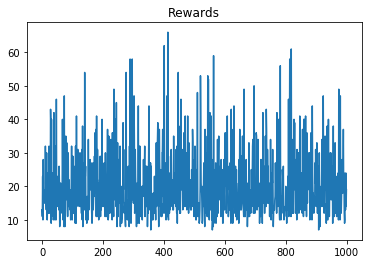

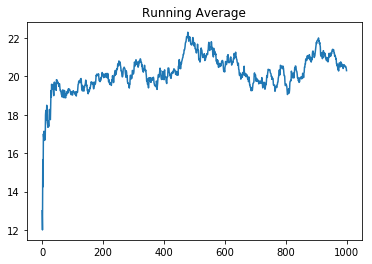

In [7]:
main()